---
---
## CURRENT PROGRESS: 
1. `sionna.rt.antenna.visualize` hor/vert plot looks good.
2. `sionna.rt.antenna.visualize` 3D plot does not seem right because we did not correctly handle the vertical pattern for [-PI, 0]; we just ignore it right now.
---
---

The following problem needs to be solved:

- [x] Python MSI parsing function
- [x] Interpolation function for hor/ver gain: MSI file will only provide the pattern in 1-degree resolution. But Sionna requires at least 0.36 a degree resolution (1000 data points for 360 degrees). Using `scipy.interpolate.interp1d`
- [ ] Zero degree definition converting: MSI and Sionna use different definitions for zero degree; we need a formal function to convert it. Check the following code.
- [ ] MSI, Sionna coordinate system conversion. Check below for details.


Seems Sionna follows the spherical coordinate system where:
- Zenith angle is measured from the top (0°) to the bottom (180°).
- Azimuth angle is measured from -180° to 180° (or equivalently 0° to 360°).

Ans MSI using:
- The vertical pattern is defined from -180° to 180° (or 0° to 360°).
- The horizontal (azimuth) pattern also spans 360°.

I'm wondering if that means we need to check the Azimuth from sionna to determine which half of the MSI vertical pattern should we used for return values.

# Sionna MSI Importer





In this notebook, we are trying to build an antenna pattern importer for Sionna to use the MSI (.msi) antenna pattern file.

**Useful Links**
- MSI File Format: http://radiomobile.pe1mew.nl/?The_program___Definitions___MSI
- MSI File Library: https://www.wireless-planning.com/msi-antenna-pattern-file-library
- Sionna Antenna class: https://nvlabs.github.io/sionna/_modules/sionna/rt/antenna.html#visualize
- Sionna Discussion: https://github.com/NVlabs/sionna/discussions/582
- Antenna Pattern Editor (Visulizae the MSI file): https://www.wireless-planning.com/antenna-pattern-editor
- `dBi` vs. `dBd`: http://radiomobile.pe1mew.nl/?The_program___Definitions___dBi

Following is the screenshot for `Canopy.msi` in `Antenna Pattern Editor`.

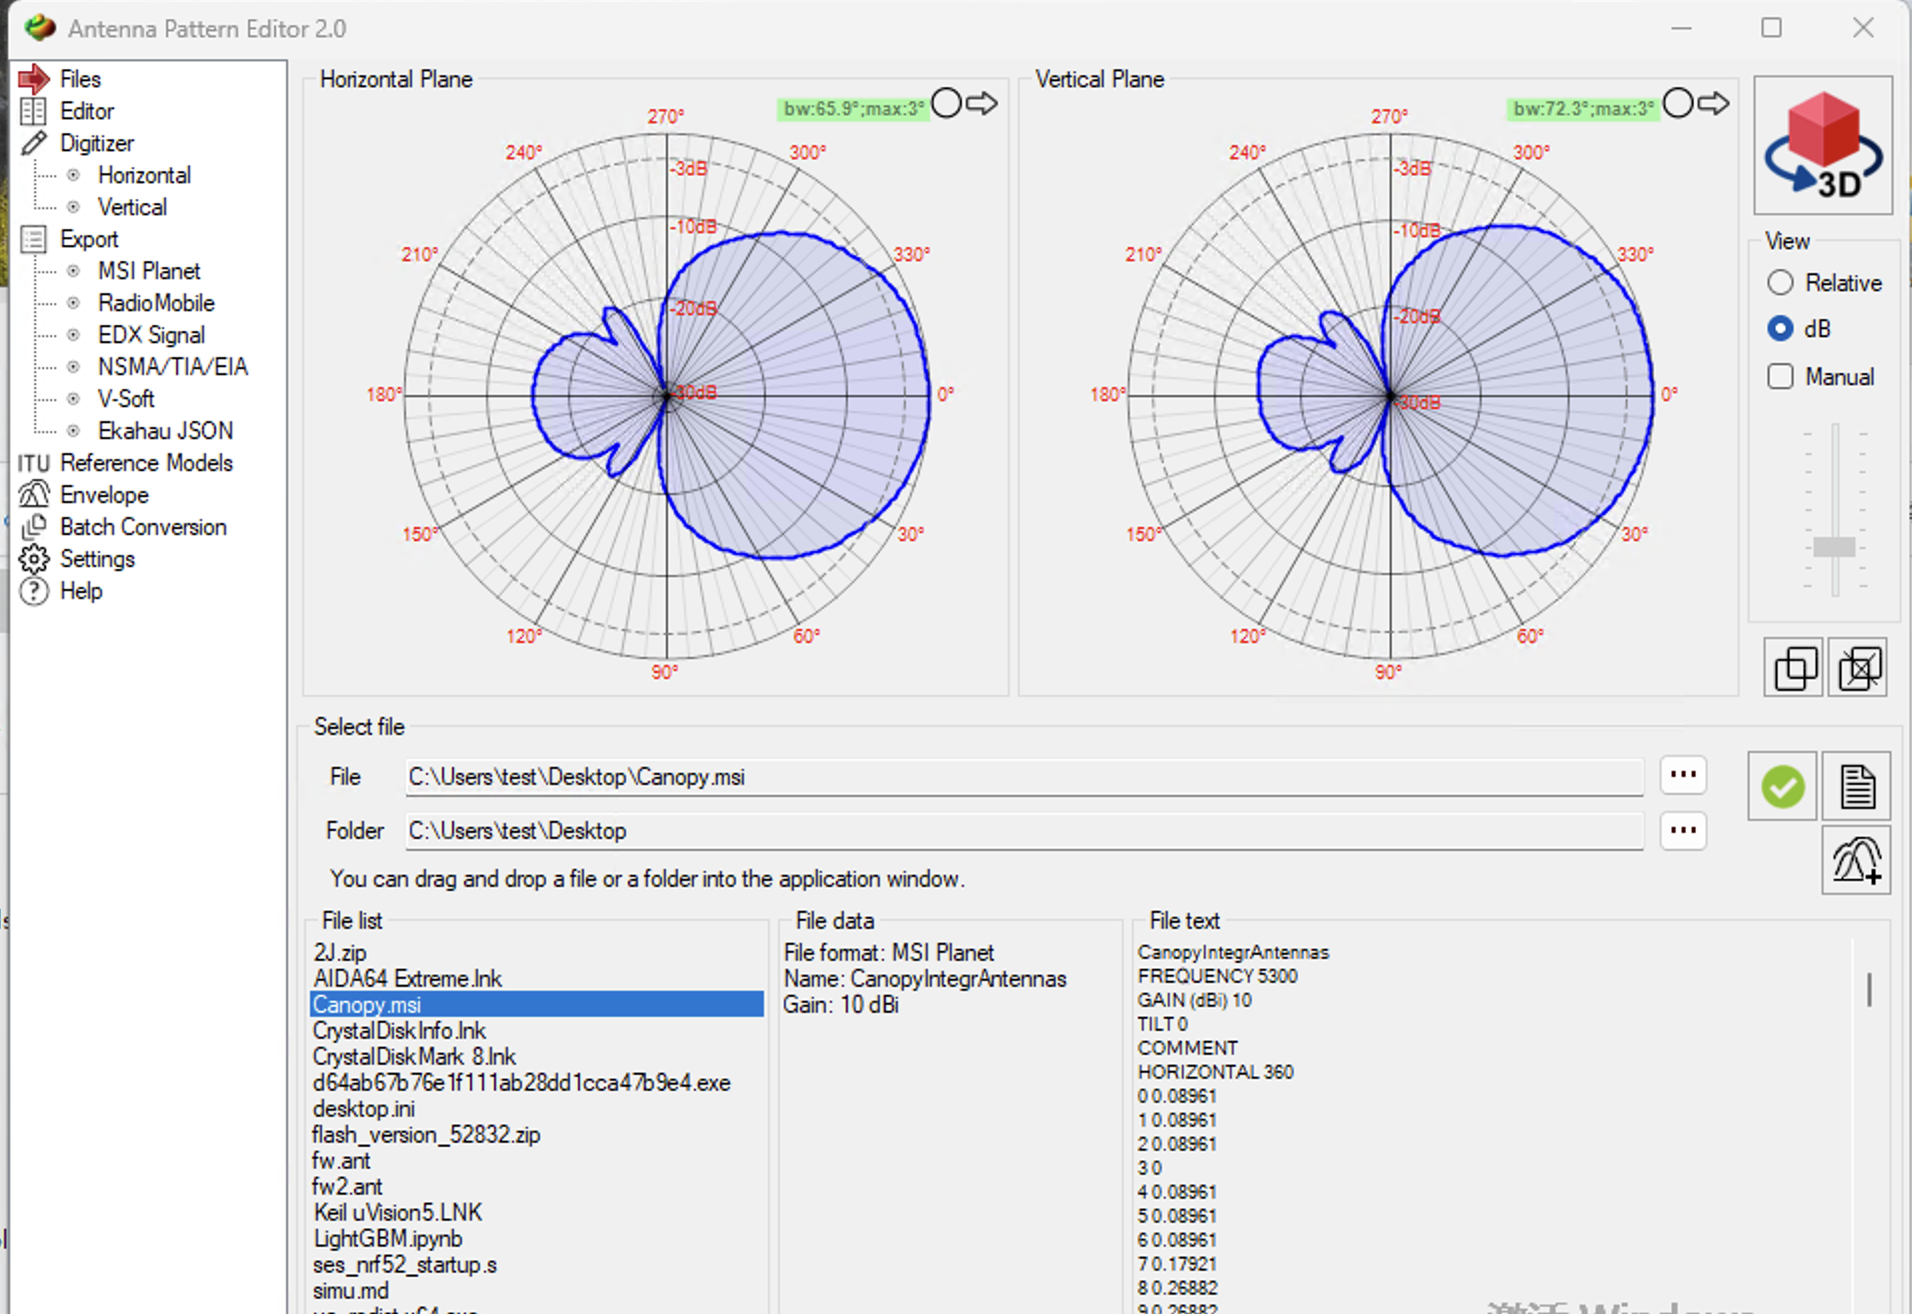
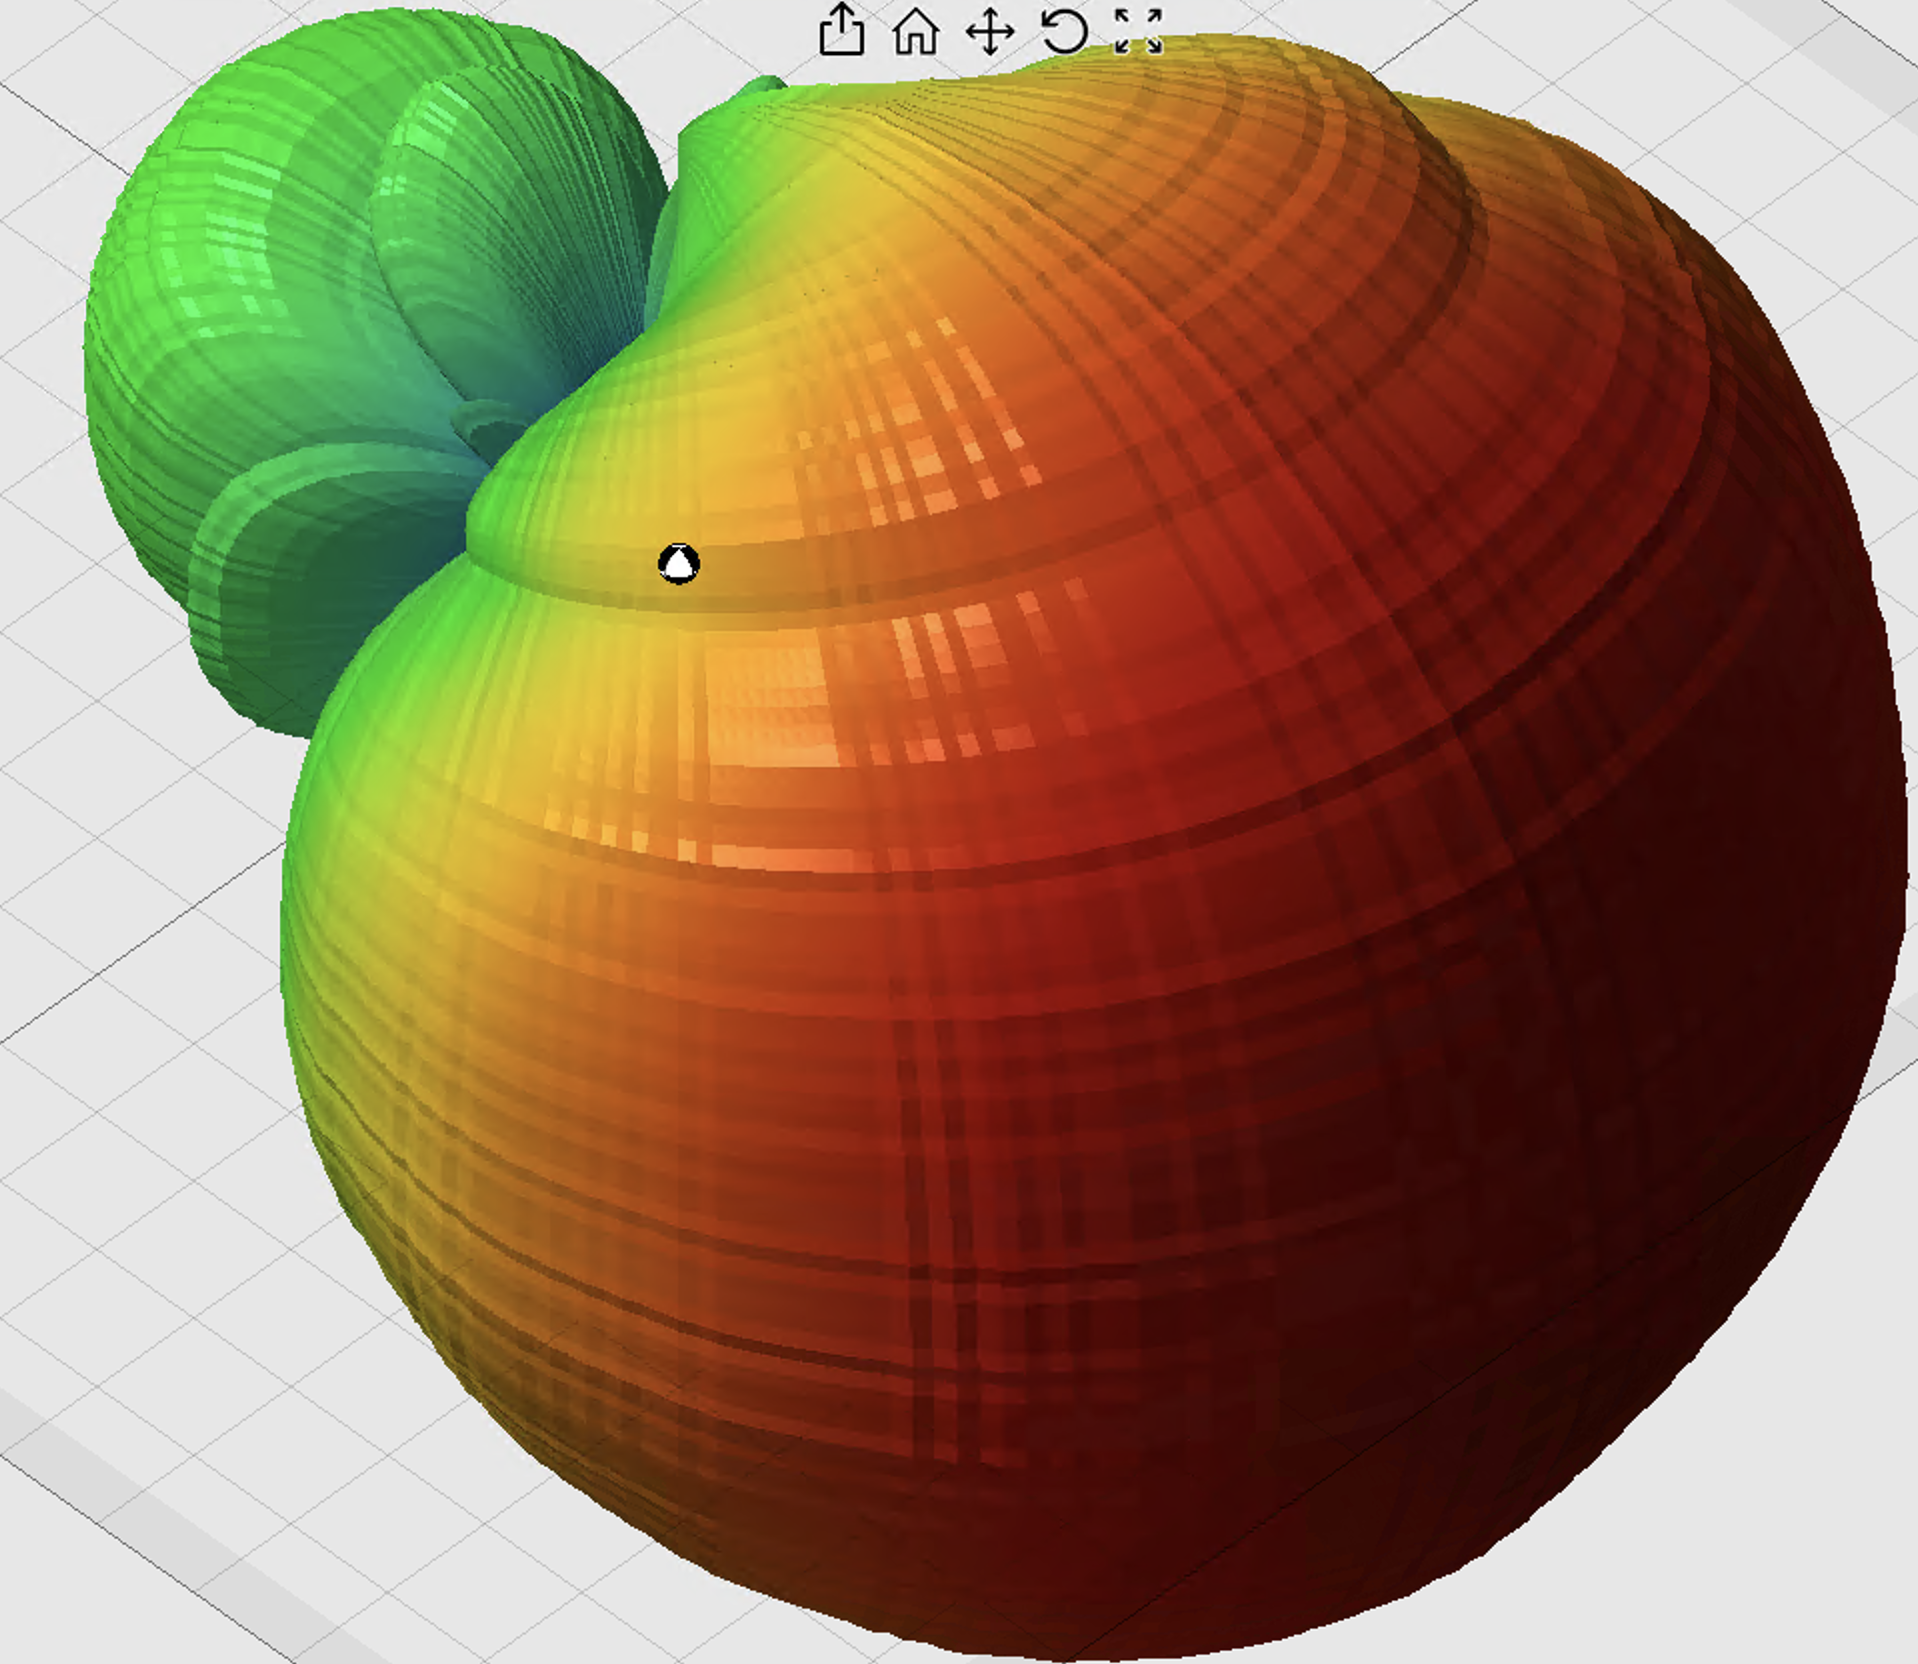

## 1. Check the Example Sionna Antenna Pattern function
First of all, let's go deeper into what the input and output are for a well-defined Sionna antenna pattern function. We will use the `sionna.rt.antenna.tr38901_pattern` as an example.

In [1]:
import tensorflow as tf
from sionna.constants import PI
import numpy as np
from sionna.rt.antenna import polarization_model_1, polarization_model_2

        
def tr38901_pattern(theta, phi, slant_angle=0.0,
                    polarization_model=2, dtype=tf.complex64):
    print("called")
    print(f"Theta type: {type(theta)}, shape: {theta.shape}")
    print(theta[:10])
    print()
    print(f"phi type: {type(phi)}, shape: {phi.shape}")
    print(phi[:10])
    print()
    r"""
    Antenna pattern from 3GPP TR 38.901 (Table 7.3-1) [TR38901]_

    Input
    -----
    theta: array_like, float
        Zenith angles wrapped within [0,pi] [rad]

    phi: array_like, float
        Azimuth angles wrapped within [-pi, pi) [rad]

    slant_angle: float
        Slant angle of the linear polarization [rad].
        A slant angle of zero means vertical polarization.

    polarization_model: int, one of [1,2]
        Polarization model to be used. Options `1` and `2`
        refer to :func:`~sionna.rt.antenna.polarization_model_1`
        and :func:`~sionna.rt.antenna.polarization_model_2`,
        respectively.
        Defaults to `2`.

    dtype : tf.complex64 or tf.complex128
        Datatype.
        Defaults to `tf.complex64`.

    Output
    ------
    c_theta: array_like, complex
        Zenith pattern

    c_phi: array_like, complex
        Azimuth pattern


    .. figure:: ../figures/tr38901_pattern.png
        :align: center
    """
    rdtype = dtype.real_dtype
    theta = tf.cast(theta, rdtype)
    phi = tf.cast(phi, rdtype)
    slant_angle = tf.cast(slant_angle, rdtype)

    # Wrap phi to [-PI,PI]
    phi = tf.math.floormod(phi+PI, 2*PI)-PI

    if not theta.shape==phi.shape:
        raise ValueError("theta and phi must have the same shape.")
    if polarization_model not in [1,2]:
        raise ValueError("polarization_model must be 1 or 2")
    theta_3db = phi_3db = tf.cast(65/180*PI, rdtype)
    a_max = sla_v = 30
    g_e_max = 8
    a_v = -tf.minimum(12*((theta-PI/2)/theta_3db)**2, sla_v)
    a_h = -tf.minimum(12*(phi/phi_3db)**2, a_max)
    a_db = -tf.minimum(-(a_v + a_h), a_max) + g_e_max
    a = 10**(a_db/10)
    c = tf.complex(tf.sqrt(a), tf.zeros_like(a))
    if polarization_model==1:
        res = polarization_model_1(c, theta, phi, slant_angle)
    else:
        res = polarization_model_2(c, slant_angle)

    print(f"res type: {type(res)}, shape: {np.array(res).shape}")
    print(res[0][:10])
    print(res[1][:10])
    print("\n")
    return res





    

2025-02-25 17:30:07.677262: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 17:30:07.680043: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 17:30:07.726927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 17:30:07.726970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 17:30:07.728339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

The following results basically show that the `visualize` function will call the `tr38901_pattern` three times and each time with the parameters as:
1. `theta = np.linspace(0.0, PI, 1000), phi = np.zeros_like(theta)`


   This is used for plotting the vertical view.


3. `phi = np.linspace(-PI, PI, 1000), theta = np.zeros_like(theta)`


   This is used for plotting the horizontal view.



5. `theta = np.linspace(0.0, PI, 50), phi = np.linspace(-PI, PI, 50)`


   This is used for plotting the 3D view.




called
Theta type: <class 'numpy.ndarray'>, shape: (1000,)
[0.         0.00314474 0.00628947 0.00943421 0.01257895 0.01572369
 0.01886842 0.02201316 0.0251579  0.02830264]

phi type: <class 'numpy.ndarray'>, shape: (1000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

res type: <class 'tuple'>, shape: (2, 1000)
tf.Tensor(
[0.17770681+0.j 0.17959955+0.j 0.18150865+0.j 0.18343407+0.j
 0.185376  +0.j 0.18733448+0.j 0.18930973+0.j 0.19130166+0.j
 0.19331045+0.j 0.19533628+0.j], shape=(10,), dtype=complex64)
tf.Tensor([0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j], shape=(10,), dtype=complex64)


called
Theta type: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1000,)
tf.Tensor(
[1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633], shape=(10,), dtype=float64)

phi type: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1000,)
tf.Tensor(
[-3.1415927 -3.1353033 -3.1290138 -3.1227243 -3.1164348

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>)

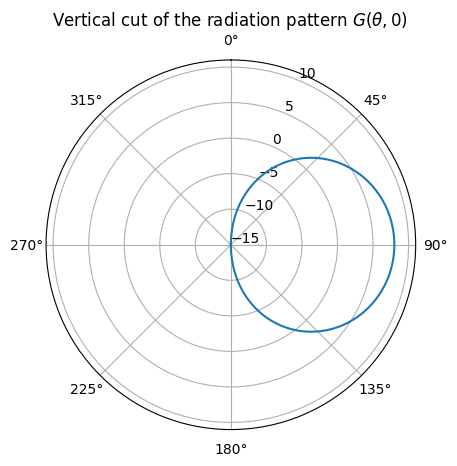

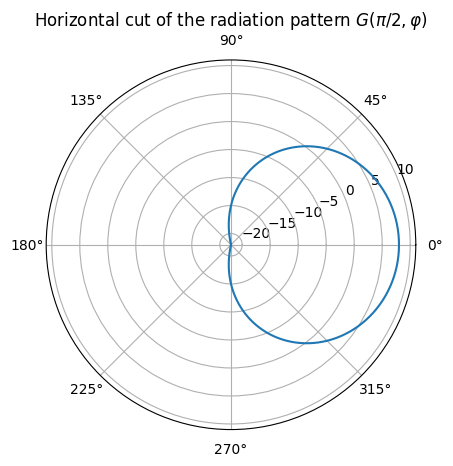

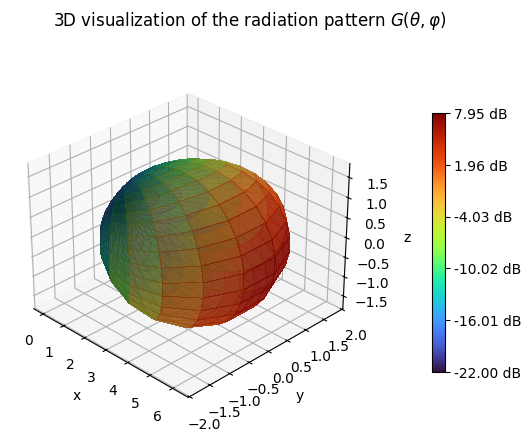

In [2]:
import sionna
sionna.rt.antenna.visualize(tr38901_pattern)


In [3]:
def parse_msi(filename):
    """
    Parse an MSI-format antenna pattern file and return:
      - metadata (dict of NAME, MAKE, GAIN, etc.)
      - horizontal_patterns (list of (angle, gain) for 360 entries)
      - vertical_patterns   (list of (angle, gain) for 360 entries)
    """
    metadata = {}
    horizontal_patterns = []
    vertical_patterns = []

    with open(filename, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]  # strip & remove empty lines

    # We’ll iterate line-by-line, collecting metadata until we hit "HORIZONTAL 360" or "VERTICAL 360"
    i = 0
    n = len(lines)

    # Simple helper function to parse angle/gain lines
    def parse_angle_gain_block(start_index, count=360):
        """Parse count lines of 'angle gain' starting from start_index, return list of (angle, gain)."""
        pattern_data = []
        for idx in range(start_index, start_index + count):
            angle_str, gain_str = lines[idx].split()
            angle = float(angle_str)
            gain = float(gain_str)
            pattern_data.append([angle, gain])
        return pattern_data

    while i < n:
        line = lines[i]

        # Check if we've encountered the horizontal block
        if line.startswith("HORIZONTAL"):
            # e.g. "HORIZONTAL 360"
            _, count_str = line.split()
            count = int(count_str)
            horizontal_patterns = parse_angle_gain_block(i+1, count)
            i += 1 + count  # Move past these lines
            continue

        # Check if we've encountered the vertical block
        if line.startswith("VERTICAL"):
            # e.g. "VERTICAL 360"
            _, count_str = line.split()
            count = int(count_str)
            vertical_patterns = parse_angle_gain_block(i+1, count)
            i += 1 + count
            continue

        # Otherwise, it should be a metadata line like "NAME", "MAKE", "GAIN", etc.
        # The typical format is: KEY [value...]
        # e.g. "NAME 2J 2J0102-C115N 2.4GHz"
        parts = line.split(maxsplit=1)
        if len(parts) == 2:
            key, val = parts
            metadata[key] = val
        elif len(parts) == 1:
            # If there's just one part (like "COMMENT" with no value), store empty string
            metadata[parts[0]] = ""
        i += 1

    return metadata, horizontal_patterns, vertical_patterns





In [4]:
import numpy as np
from scipy.interpolate import interp1d

import sionna

import tensorflow as tf
from sionna.constants import PI
import numpy as np
from sionna.rt.antenna import polarization_model_1, polarization_model_2

import matplotlib.pyplot as plt



def get_antenna_pattern(msi_vertical, msi_horizontal, azimuth_list, zenith_list):
    """
    Compute the interpolated antenna gain based on MSI vertical and horizontal patterns.

    Parameters:
    - msi_vertical: List of 360 vertical gains (one per degree, from 0° to 359°).
    - msi_horizontal: List of 360 horizontal gains (one per degree, from 0° to 359°).
    - azimuth_list: List of azimuth angles in pi units.
    - zenith_list: List of zenith angles in pi units.

    Returns:
    - gain_values: 2D NumPy array of interpolated gain values for given azimuth and zenith angles.
    """
    # Convert azimuth and zenith from pi units to degrees
    azimuth_deg = np.array(azimuth_list) * 180/3.14  # Convert azimuth from π units to degree

    # Seems Sioona have a different zero representation than MSI
    # MSI defined the zero as:
    #    Zero degrees represents North for the Horizontal pattern,
    #    Zero degrees represents the horizon for the Vertical pattern.
    azimuth_deg =  azimuth_deg + 360 #
    azimuth_deg = np.mod(azimuth_deg, 360)
    
    zenith_deg = np.array(zenith_list) * 180/3.14  # Convert zenith from π units to degrees
    zenith_deg = np.where(zenith_deg <= 90, 270 + zenith_deg , zenith_deg - 90)


    
    # Define original MSI angle grid (0° to 359°)
    angles = np.arange(0, 360, 1)

    # Interpolate MSI gains
    vert_interp = interp1d(angles, msi_vertical, kind='linear')
    hor_interp = interp1d(angles, msi_horizontal, kind='linear')

    # Ensure angles wrap around (360° = 0° in MSI pattern)
    azimuth_deg = np.clip(azimuth_deg, 0,359)
    zenith_deg = np.clip(zenith_deg, 0,359)


    # Interpolate gains for the provided angles
    interpolated_vert = vert_interp(zenith_deg)  # Get vertical gain at given zenith angles
    interpolated_hor = hor_interp(azimuth_deg)  # Get horizontal gain at given azimuth angles


    # Convert gain values to TensorFlow complex64 tensor (imaginary part is zero)
    gain_tensor_ver = tf.complex(tf.convert_to_tensor(interpolated_vert, dtype=tf.float32), tf.zeros_like(interpolated_vert, dtype=tf.float32))
    gain_tensor_hor = tf.complex(tf.convert_to_tensor(interpolated_hor, dtype=tf.float32), tf.zeros_like(interpolated_hor, dtype=tf.float32))

    # 
    gain_values = interpolated_vert * interpolated_hor

    gain_tensor = tf.complex(tf.convert_to_tensor(gain_values, dtype=tf.float32), tf.zeros_like(interpolated_hor, dtype=tf.float32))


    return gain_tensor, tf.complex(tf.zeros_like(interpolated_vert, dtype=tf.float32), tf.zeros_like(interpolated_vert, dtype=tf.float32))
    


Max Vert -0.0
Max Hor -0.0
Max Vert -0.0
Max Hor -0.0
Max Vert -0.0
Max Hor -0.0


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>)

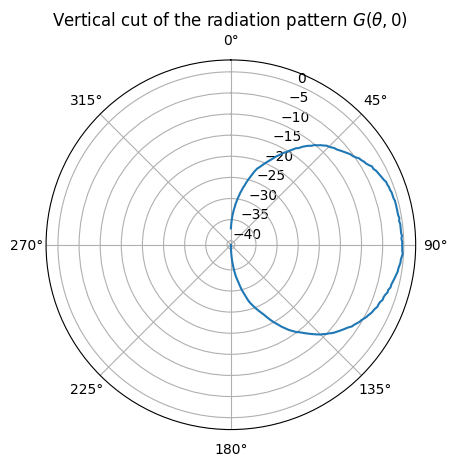

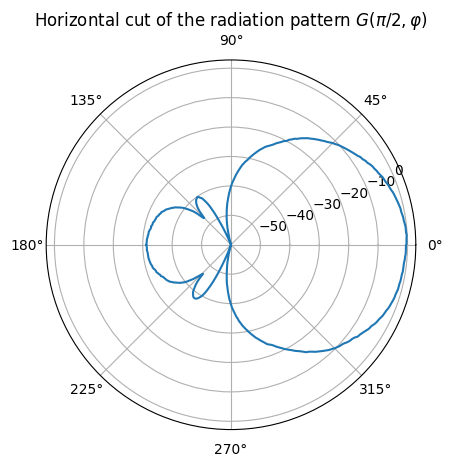

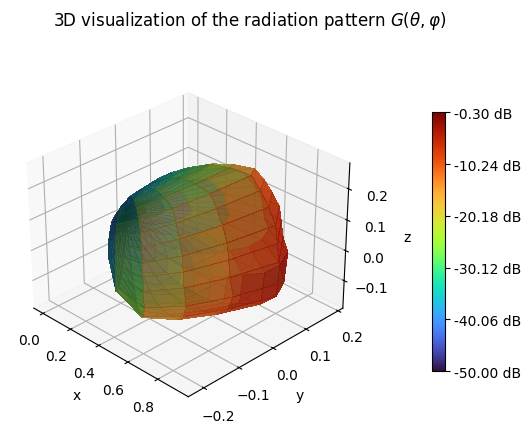

In [5]:
def wrap_function(theta, phi, slant_angle=0.0,
                    polarization_model=2, dtype=tf.complex64):


    filename = "Canopy.msi"  # replace with your MSI file path
    meta, msi_horizontal, msi_vertical = parse_msi(filename)
    msi_horizontal = np.array(msi_horizontal)[:,1] * -1 
    msi_vertical =  np.array(msi_vertical)[:,1]  * -1 
    print("Max Vert",max(msi_vertical))
    print("Max Hor",max(msi_horizontal))

    
    
   
    

    #plot_horizontal_pattern(msi_horizontal)

    
    # Covert the dB scale to linear scale
    msi_hor_linear = 10 ** (msi_horizontal/10)
    msi_ver_linear = 10 ** (msi_vertical/10)

    
    res = get_antenna_pattern(msi_ver_linear, msi_hor_linear, phi, theta)

    return res

    
sionna.rt.antenna.visualize(wrap_function)
